Claim Number is a unique identifier for each row and is not being used to regress on the data and is thus not imported.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Data/actuarial/train.csv', index_col= 'ClaimNumber')

I'll start the EDA with some basic python commands to get an idea of the structure of the data.

In [3]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 54000 entries, WC8285054 to WC2542601
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTimeOfAccident         54000 non-null  object 
 1   DateReported               54000 non-null  object 
 2   Age                        54000 non-null  int64  
 3   Gender                     54000 non-null  object 
 4   MaritalStatus              53971 non-null  object 
 5   DependentChildren          54000 non-null  int64  
 6   DependentsOther            54000 non-null  int64  
 7   WeeklyWages                54000 non-null  float64
 8   PartTimeFullTime           54000 non-null  object 
 9   HoursWorkedPerWeek         54000 non-null  float64
 10  DaysWorkedPerWeek          54000 non-null  int64  
 11  ClaimDescription           54000 non-null  object 
 12  InitialIncurredCalimsCost  54000 non-null  int64  
 13  UltimateIncurredClaimCost  54000 non-nu

The dataset contains 54,000 observations of fourteen variables. Date Time Of Accident provides information on when the accident occured, and Date Reported tells when the accident was reported. We are given the age, gender, and marital status of the claimant along with whether or not they have children or other dependents that rely on them for care. We also have employment information for the claimints including their weekly wages, how many hours per day, and days per week they work, and a binary classifier for full time vs part time. Finally we have a claim description and the initial claim cost estimation by the insurer, and then our target variable the ultimate incurred cost of the claim.

In [4]:
print(df.describe())

                Age  DependentChildren  DependentsOther   WeeklyWages  \
count  54000.000000       54000.000000     54000.000000  54000.000000   
mean      33.842370           0.119185         0.009944    416.364807   
std       12.122165           0.517780         0.109348    248.638669   
min       13.000000           0.000000         0.000000      1.000000   
25%       23.000000           0.000000         0.000000    200.000000   
50%       32.000000           0.000000         0.000000    392.200000   
75%       43.000000           0.000000         0.000000    500.000000   
max       81.000000           9.000000         5.000000   7497.000000   

       HoursWorkedPerWeek  DaysWorkedPerWeek  InitialIncurredCalimsCost  \
count        54000.000000       54000.000000               5.400000e+04   
mean            37.735084           4.905759               7.841146e+03   
std             12.568704           0.552129               2.058408e+04   
min              0.000000           1.0000

There are some issues with this data. The hours worked per week column contains multiple entries that are completely impossible, such as the max of 640 hours in a week.

In [5]:
# Find rows where weekly hours exceed 80 OR daily hours exceed 12
hours_outliers = df[(df['HoursWorkedPerWeek'] > 80) | 
                    (df['HoursWorkedPerWeek'] / df['DaysWorkedPerWeek'] > 12)]

print(f"Number of rows with outliers: {hours_outliers.shape[0]}")
print(hours_outliers[hours_outliers['HoursWorkedPerWeek'] < 80])

Number of rows with outliers: 463
               DateTimeOfAccident          DateReported  Age Gender  \
ClaimNumber                                                           
WC2986786    1990-04-26T11:00:00Z  1990-06-05T00:00:00Z   47      M   
WC7329688    2000-12-21T10:00:00Z  2001-01-20T00:00:00Z   34      M   
WC4315534    1993-01-31T12:00:00Z  1993-05-14T00:00:00Z   57      M   
WC7358909    2000-12-13T16:00:00Z  2001-01-18T00:00:00Z   44      M   
WC4940427    1995-02-21T09:00:00Z  1995-04-12T00:00:00Z   41      M   
...                           ...                   ...  ...    ...   
WC3880830    1992-01-13T16:00:00Z  1992-04-23T00:00:00Z   39      M   
WC8630257    2003-12-10T16:00:00Z  2003-12-22T00:00:00Z   39      F   
WC3026764    1991-01-10T15:00:00Z  1991-01-30T00:00:00Z   36      M   
WC2173419    1989-08-03T15:00:00Z  1989-08-26T00:00:00Z   36      M   
WC8844842    2003-06-11T11:00:00Z  2003-07-20T00:00:00Z   49      M   

            MaritalStatus  DependentChildr

There are 463 rows with hours worked per week > 84 or hours per day > 12. In order to get these values in line I feel there are three good options. One, would be to simply take the number of days worked per week and multiply it times 12 hours per day and set that as that rows hours per week. This takes impossible values and smashes them down to the maximum plausible hours. Two, would be to take the average hours worked per day (excluding the outliers) and multiply that number by days worked and that would make these outliers fall in line with the rest of the data. Three, of course, would be to delete the rows with this data. The possible problem with path 3 is that if the hours worked per week or per day is only weakly correlated with the target then we could potentially be throwing out other valuable information. The other two methods have downsides as well of course.

My correlation heatmap shows almost zero correlation across the board between hours worked per week and any other variable. I believe then that simply using the average of other values would allow me to keep as much data in the dataset as possible without altering the predictive accuracy.

In [6]:
# Calculate realistic daily average (excluding extreme values)
avg_daily_hours = df[df['HoursWorkedPerWeek'] <= 84]['HoursWorkedPerWeek'].mean() / 7

# Adjust values where hours per week > 80 or hours per day > 12
df.loc[(df['HoursWorkedPerWeek'] > 80) | 
       (df['HoursWorkedPerWeek'] / df['DaysWorkedPerWeek'] > 12), 
       'HoursWorkedPerWeek'] = df['DaysWorkedPerWeek'] * avg_daily_hours

The data has hours per week, and days per week. For workmans comp claims it may be interesting to look also at hours worked per day when predicting the target. People get tired over long periods of time and those working greater than a certain threshold could be more susceptible to bad injuries. So I've engineered another feature as hours/day.

In [7]:
df['HoursWorkedPerDay'] = df['HoursWorkedPerWeek'] / df['DaysWorkedPerWeek']

In [8]:
print(df.describe(include='O'))

          DateTimeOfAccident          DateReported Gender MaritalStatus  \
count                  54000                 54000  54000         53971   
unique                 36673                  6653      3             3   
top     2001-05-01T14:00:00Z  2001-03-29T00:00:00Z      M             S   
freq                       9                    25  41660         26161   

       PartTimeFullTime                             ClaimDescription  
count             54000                                        54000  
unique                2                                        28114  
top                   F  SLIPPED ON ROLLER TENDONITIS RIGHT SHOULDER  
freq              49112                                          289  


In [9]:
print(df.isnull().sum())

DateTimeOfAccident            0
DateReported                  0
Age                           0
Gender                        0
MaritalStatus                29
DependentChildren             0
DependentsOther               0
WeeklyWages                   0
PartTimeFullTime              0
HoursWorkedPerWeek            0
DaysWorkedPerWeek             0
ClaimDescription              0
InitialIncurredCalimsCost     0
UltimateIncurredClaimCost     0
HoursWorkedPerDay             0
dtype: int64


The marital status column has 29 null values. This data represents whether or not the claimant is married and has 3 values: married, single, and unknown. Null values for this data can simply be changed to U for unknown and no data should be removed.

In [10]:
df['MaritalStatus'] = df['MaritalStatus'].fillna('U')
print(df.describe(include='O'))

          DateTimeOfAccident          DateReported Gender MaritalStatus  \
count                  54000                 54000  54000         54000   
unique                 36673                  6653      3             3   
top     2001-05-01T14:00:00Z  2001-03-29T00:00:00Z      M             S   
freq                       9                    25  41660         26161   

       PartTimeFullTime                             ClaimDescription  
count             54000                                        54000  
unique                2                                        28114  
top                   F  SLIPPED ON ROLLER TENDONITIS RIGHT SHOULDER  
freq              49112                                          289  


In [11]:
print(df.dtypes)

DateTimeOfAccident            object
DateReported                  object
Age                            int64
Gender                        object
MaritalStatus                 object
DependentChildren              int64
DependentsOther                int64
WeeklyWages                  float64
PartTimeFullTime              object
HoursWorkedPerWeek           float64
DaysWorkedPerWeek              int64
ClaimDescription              object
InitialIncurredCalimsCost      int64
UltimateIncurredClaimCost    float64
HoursWorkedPerDay            float64
dtype: object


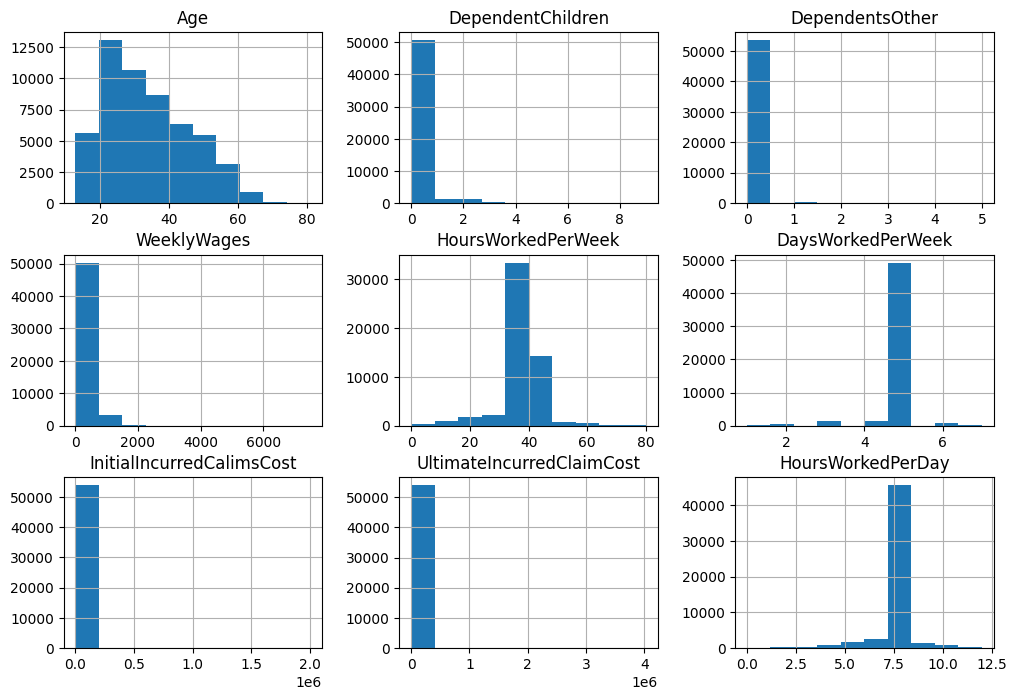

In [12]:
df.hist(figsize=(12, 8))
plt.show()

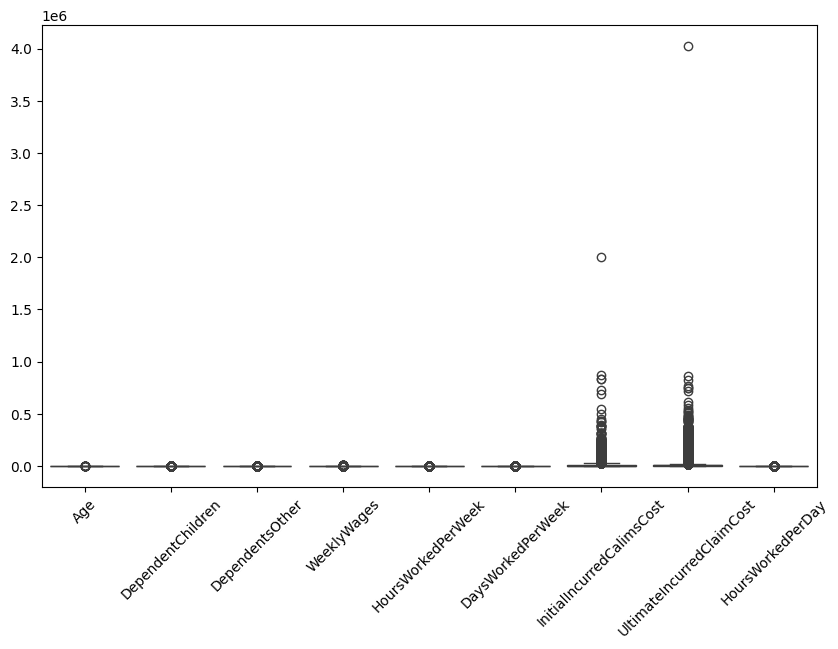

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.select_dtypes(include='number'))
plt.xticks(rotation=45)
plt.show()

There are potential outliers in initial and ultimate cost.

In [14]:
# Identify outliers in 'InitialIncurredCalimsCost'
Q1_initial = df['InitialIncurredCalimsCost'].quantile(0.25)
Q3_initial = df['InitialIncurredCalimsCost'].quantile(0.75)
IQR_initial = Q3_initial - Q1_initial

outliers_initial = df[(df['InitialIncurredCalimsCost'] < (Q1_initial - 1.5 * IQR_initial)) | 
                      (df['InitialIncurredCalimsCost'] > (Q3_initial + 1.5 * IQR_initial))]

# Identify outliers in 'UltimateIncurredClaimCost'
Q1_ultimate = df['UltimateIncurredClaimCost'].quantile(0.25)
Q3_ultimate = df['UltimateIncurredClaimCost'].quantile(0.75)
IQR_ultimate = Q3_ultimate - Q1_ultimate

outliers_ultimate = df[(df['UltimateIncurredClaimCost'] < (Q1_ultimate - 1.5 * IQR_ultimate)) | 
                        (df['UltimateIncurredClaimCost'] > (Q3_ultimate + 1.5 * IQR_ultimate))]

# Combine both sets of outliers
outliers = pd.concat([outliers_initial, outliers_ultimate]).drop_duplicates()

print(outliers.shape[0])

7333


In [15]:
# Find the index of the row with the max value in 'UltimateIncurredClaimCost'
max_idx_1 = df['UltimateIncurredClaimCost'].idxmax()
max_idx_2 = df['InitialIncurredCalimsCost'].idxmax()

# Drop that row from the dataset
df = df.drop(index=max_idx_1)
df = df.drop(index=max_idx_2)

Using both IQR and standard deviation as a means of culling outliers in claims valuable proved to be a bad idea as hundreds to thousands of rows get flagged. Instead I simply used the box and whisker plot to remove the most extreme outlier from both claims columns and this gave much better results. Both columns has a long right tail and this makes sense as medical costs will be clustered around a lowish median with bad hospitalizations have dramatically higher costs.

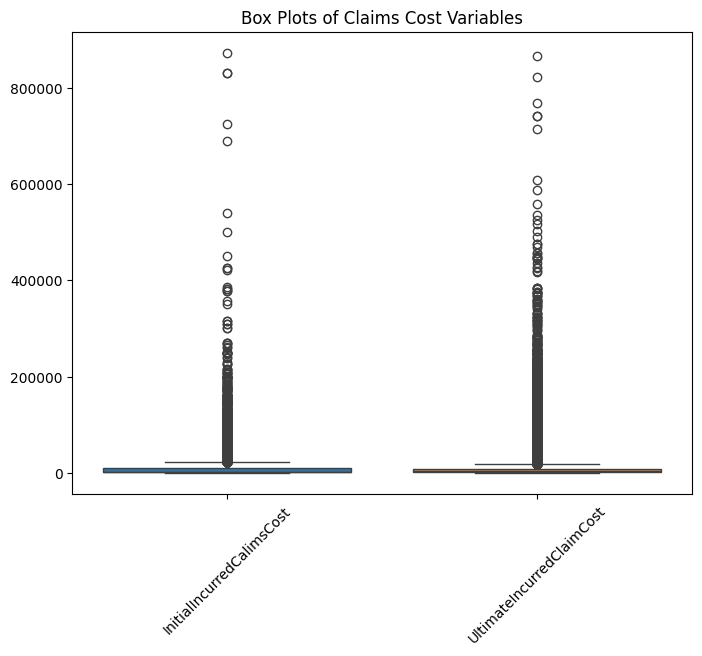

In [16]:

# Define columns to visualize
columns_to_plot = ['InitialIncurredCalimsCost', 'UltimateIncurredClaimCost']

# Create the box plots
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[columns_to_plot])
plt.xticks(rotation=45)
plt.title('Box Plots of Claims Cost Variables')
plt.show()

There are two columns for date. The first is the date of the incident, and the 2nd is the date the incident was reported. When an accident happened, or when it was reported would have no bearing on the amount of the claim. However we can engineer a potentially interesting variable by taking the delta of the two columns. There may be some correlation between the reporting delta and final claims amount.

In [17]:
# Convert columns to datetime format
df['DateTimeOfAccident'] = pd.to_datetime(df['DateTimeOfAccident'], utc=True)
df['DateReported'] = pd.to_datetime(df['DateReported'], utc=True)

# Calculate reporting delay (delta in days)
df['ReportingDelta'] = (df['DateReported'] - df['DateTimeOfAccident']).dt.days

# Preview the dataset
print(df[['DateTimeOfAccident', 'DateReported', 'ReportingDelta']].head())
df

                   DateTimeOfAccident              DateReported  \
ClaimNumber                                                       
WC8285054   2002-04-09 07:00:00+00:00 2002-07-05 00:00:00+00:00   
WC6982224   1999-01-07 11:00:00+00:00 1999-01-20 00:00:00+00:00   
WC5481426   1996-03-25 00:00:00+00:00 1996-04-14 00:00:00+00:00   
WC9775968   2005-06-22 13:00:00+00:00 2005-07-22 00:00:00+00:00   
WC2634037   1990-08-29 08:00:00+00:00 1990-09-27 00:00:00+00:00   

             ReportingDelta  
ClaimNumber                  
WC8285054                86  
WC6982224                12  
WC5481426                20  
WC9775968                29  
WC2634037                28  


,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost,HoursWorkedPerDay,ReportingDelta
ClaimNumber,,,,,,,,,,,,,,,,
WC8285054,2002-04-09 07:00:00+00:00,2002-07-05 00:00:00+00:00,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388,7.6,86
WC6982224,1999-01-07 11:00:00+00:00,1999-01-20 00:00:00+00:00,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819,7.5,12
WC5481426,1996-03-25 00:00:00+00:00,1996-04-14 00:00:00+00:00,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087,7.6,20
WC9775968,2005-06-22 13:00:00+00:00,2005-07-22 00:00:00+00:00,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170,7.6,29
WC2634037,1990-08-29 08:00:00+00:00,1990-09-27 00:00:00+00:00,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925,7.6,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC9370727,2004-08-21 18:00:00+00:00,2004-09-08 00:00:00+00:00,32,F,S,0,0,500.00,F,38.0,5,STRUCK KNIFE LACERATED LEFT MIDDLE FINGER LEFT...,1000,480.493308,7.6,17
WC8396269,2002-04-28 09:00:00+00:00,2002-09-03 00:00:00+00:00,20,F,S,0,0,500.00,F,40.0,5,LEFT HAND LACERATION LEFT SIDE BACK AND LEFT LEG,1000,755.735319,8.0,127
WC3609528,1992-02-28 09:00:00+00:00,1992-03-18 00:00:00+00:00,19,M,S,0,0,283.00,F,40.0,5,METAL SLIPPED ACROSS METAL CUT FINGER,210,418.178461,8.0,18


The data here ranges from 1988 to 2005. We cannot directly compare and regress on monetary values across a 17 year span without taking inflation into account. Seasonally adjusted inflation data was taken from https://fred.stlouisfed.org/series/CPIAUCSL The Federal Reserve Bank of St. Louis, and shows CPI values for every month from January 1980 to December 2024. Inflation adjusted amounts were calculated for both initial estimated claims and final claim amounts using the formula $\text{Year 2 Price} = \text{Year 1 Price}\left(\displaystyle\frac{\text{Year 2 CPI}}{\text{Year 1 CPI}}\right)$

In [18]:
print(df['DateTimeOfAccident'].dt.year.min())
print(df['DateTimeOfAccident'].dt.year.max())

CPI = pd.read_csv(r'C:\Users\brien\OneDrive - University of California, Davis\UC Davis\Spring 2025\STA 160\Final Project\Data\CPI.csv')

# Convert columns to datetime format
CPI['observation_date'] = pd.to_datetime(CPI['observation_date']).dt.to_period('M')

1988
2005


In [19]:
df_adj = df.copy()

# Get CPI value for December 2024
current_CPI = CPI[CPI['observation_date'] == '2024-12']['CPIAUCSL'].values[0]

df_adj['DateReported'] = pd.to_datetime(df_adj['DateReported']).dt.to_period('M')

# Adjust existing claim cost columns for inflation
df_adj['InitialIncurredCalimsCost'] *= current_CPI / df_adj['DateReported'].map(CPI.set_index('observation_date')['CPIAUCSL'])
df_adj['UltimateIncurredClaimCost'] *= current_CPI / df_adj['DateReported'].map(CPI.set_index('observation_date')['CPIAUCSL'])

C:\Users\brien\AppData\Local\Temp\ipykernel_2888\497554432.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_adj['DateReported'] = pd.to_datetime(df_adj['DateReported']).dt.to_period('M')


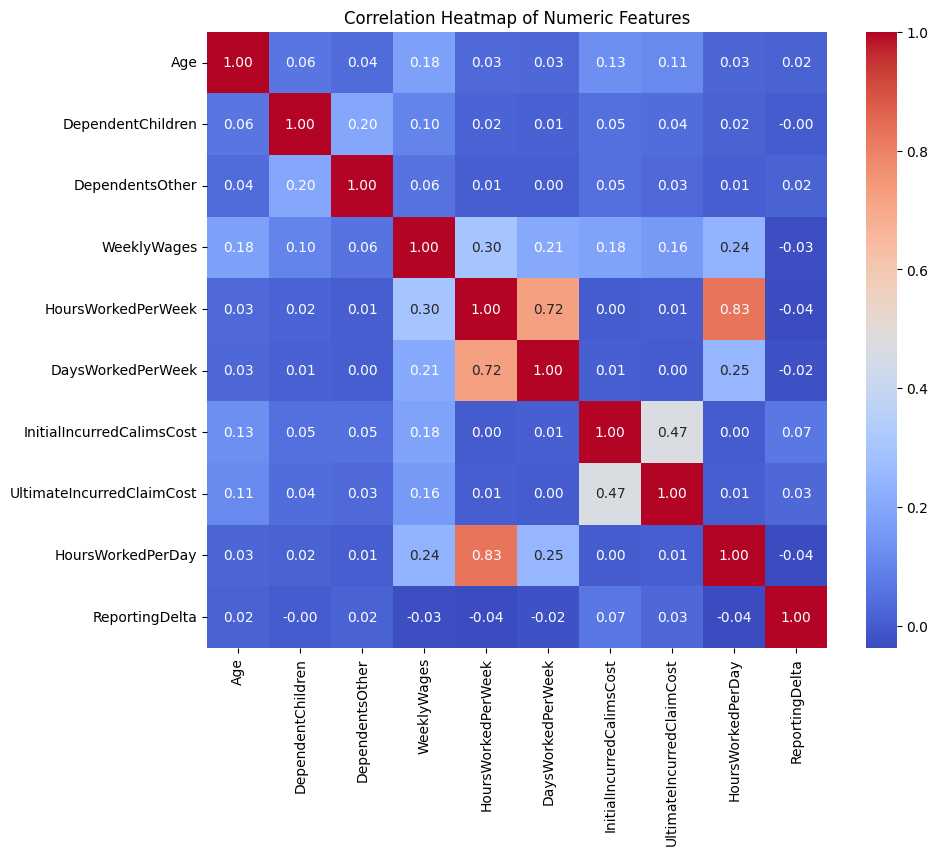

In [20]:
predictors = df_adj.select_dtypes(include = ['int64', 'float64'])
corr_matrix = predictors.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

<Figure size 800x500 with 0 Axes>

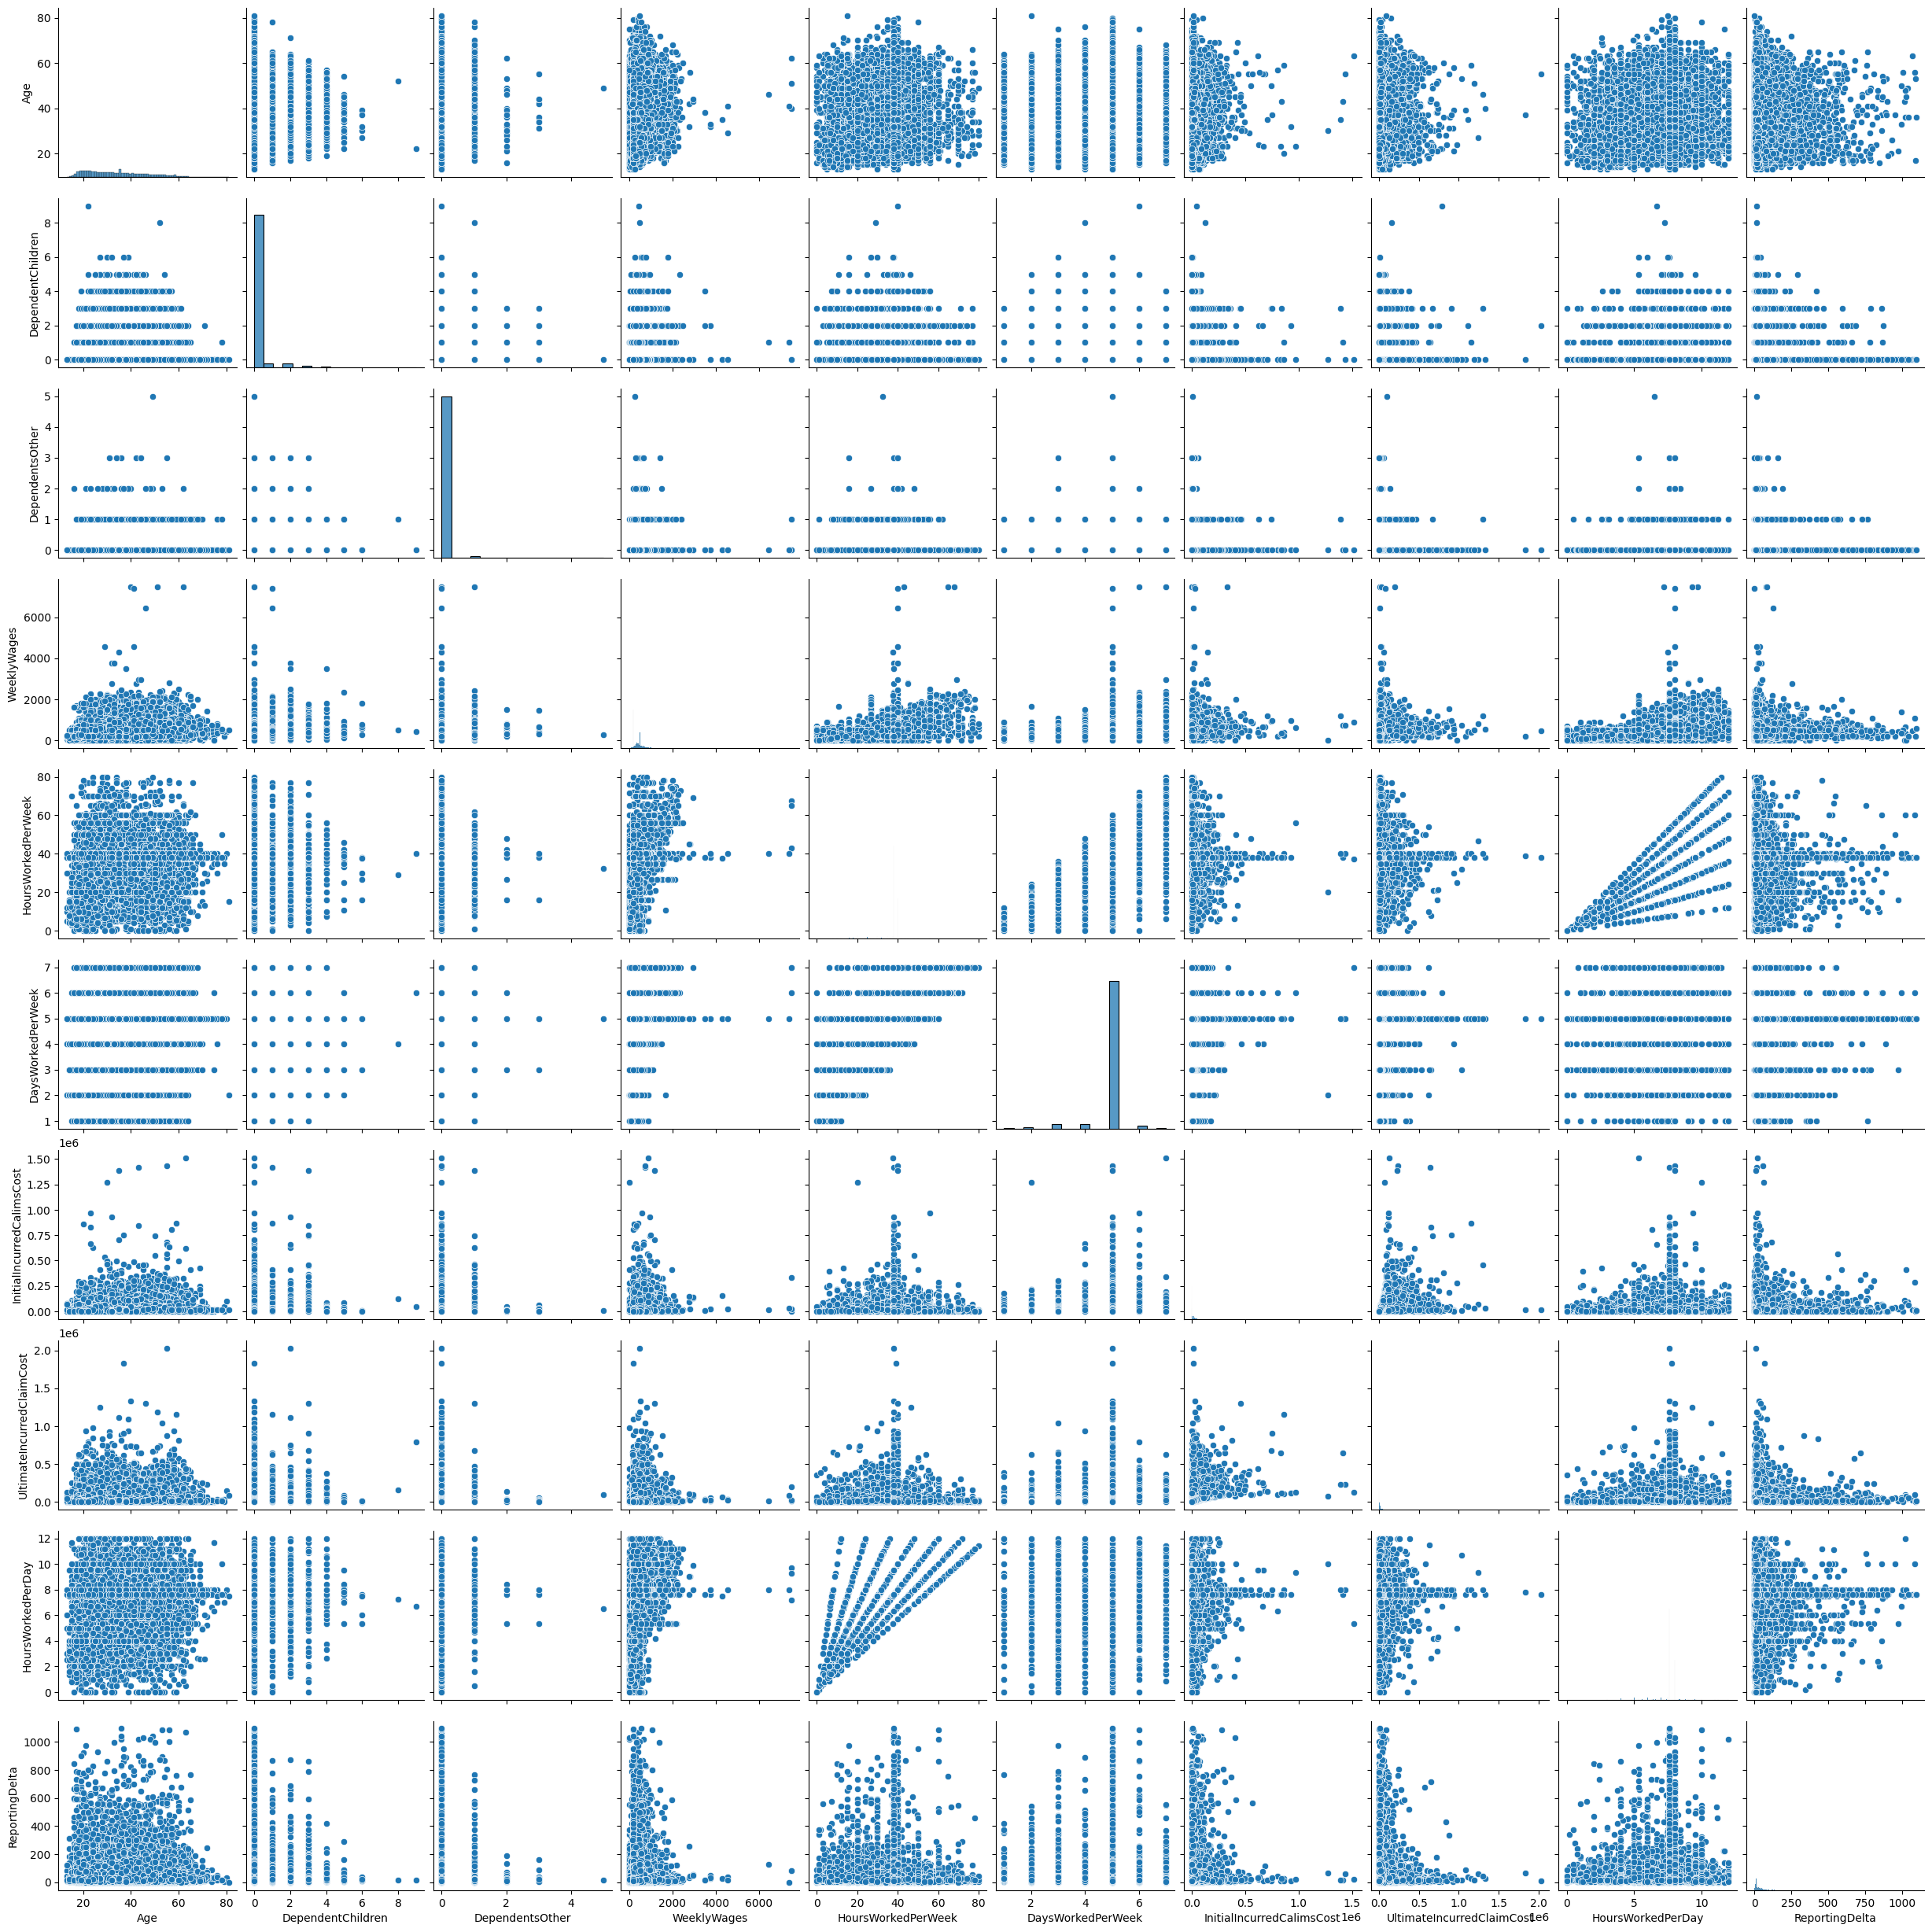

In [21]:
plt.figure(figsize=(8, 5))
sns.pairplot(predictors)
plt.show()

In [23]:
df.to_csv('Data/EDA.csv')